In [1]:
import gc
import os

import keras
from keras import layers, models, optimizers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from scipy import signal
from sklearn import cluster, metrics
import tensorflow as tf

In [2]:
#tf.test.is_gpu_available()
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Problem 

The problem statement is described in detail [here](https://archive.ics.uci.edu/ml/datasets/PPG-DaLiA).  Fifteen subjects were asked to wear a chest-mounted device and a wrist-mounted device and perform a range of activities: 
* **Sitting**: Sitting still while reading.
* **Ascending and descending stairs**: Climbing six floors up and going down again. 
* **Playing table soccer**
* **Cycling**: Performed outdoors about 2km length with varying road conditions (gravel, paved).
* **Driving a car**: Subjects followed a defined route which took about 15 minutes to complete. The route included driving on different streets in a small city as well
as driving on country roads.
* **Lunch break**: The activity included queuing and fetching food, eating, and talking at the table.
* **Walking**: Walking back from the canteen to the office, with some detour.
* **Working**: For each subject, work mainly consisted of working on a computer.

ECG signals were measured using the chest-mounted device at a 700Hz sampling frequency.  PPG and wrist acceleration signals were measured using the wrist-mounted device at 64Hz sampling frequency.  The ECG signal was segmented into frames of 8 seconds and 2 second shifts (75% overlap between frames).  The segmented ECG signal was used to calculate heart rate ground truth, provided as a 'label' array. 

The goal was to build a machine learning model to predict heart rate from the ECG device, synchronized to the ECG-derived 'label' data for comparison to the ground truth.   

# Solution

The solution involved comparing two approaches to ECG-based heart rate detection: 
* **Approach 1**: simple peak detection (non-ML)
* **Approach 2**: neural networks (ML based)  

The ECG signal was resampled (from 700 Hz to 64 Hz) for comparison to the PPG signal, after making sure that the signal was bandlimited to 32 Hz. The resampled ECG signal was then segmented into 8 second frames with a 2 second shift (75% overlap between frames) to align with the 'label' data.   
    
For the simple peak detection based method, all data was used for testing.  For the ML based approach, data from the subjects 1-7 was used for training, data from subjects 8-11 was used for validation, and data from subjects 12-15 was used for testing/inference.   

The two approaches for heart rate detection were compared: 
* **Approach 1**: simple R-wave peak detector and beat-to-beat interval estimator were implemented on each frame and an average heart rate was computed for each frame
* **Approach 2**: time domain neural networks (CONV1D and LSTM) were used to process the time-domain ECG signal, to estimate heart rate as a regression problem 

In both cases, MAE (in bpm) was computed using the heart rate obtained with and without post-processing.  For post-processing, the Savitzky-Golay smoothing filter was used to reduce variability of detected heart rate between frames. 

The results (test MAE) obtained were as follows: 

| Model Architecture | Signal Postprocessing | MAE (bpm) |
|--------------------|-----------------------|-----------|
| Approach 1 (non-ML) | No            | 4.19 |
| Approach 1 (non-ML) | Yes           | 4.08 |
| Approach 2 (ML-based)    | No            | 5.62 |
| Approach 2 (ML-based)    | Yes           | 5.61  |


## Exploratory Analysis of Data

In [39]:
with open('PPG_FieldStudy/S2/S2.pkl', 'rb') as file:
    data_dict = pickle.load(file, encoding='latin1')

In [40]:
print(data_dict.keys())
print(data_dict['signal'].keys())
print(data_dict['signal']['chest'].keys())
print(data_dict['signal']['wrist'].keys())
print(data_dict['signal']['wrist']['BVP'].shape)
print(data_dict['label'].shape)

dict_keys(['rpeaks', 'signal', 'label', 'activity', 'questionnaire', 'subject'])
dict_keys(['chest', 'wrist'])
dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp'])
dict_keys(['ACC', 'BVP', 'EDA', 'TEMP'])
(525120, 1)
(4099,)


In [41]:
labels = data_dict['label']
print(labels)

[70.9229657  71.29105528 68.69383264 ... 95.13817648 96.7405001
 96.84438537]


In [42]:
chest_signals = data_dict['signal']['chest']
wrist_signals = data_dict['signal']['wrist']

chest_acc = chest_signals['ACC']
ecg = chest_signals['ECG']
wrist_ppg = wrist_signals['BVP']
wrist_acc = wrist_signals['ACC']

ecg_downsamp = signal.resample_poly(ecg, up=64, down=700)
acc_interp = signal.resample_poly(wrist_acc, up=2, down=1)

In [43]:
print(len(wrist_ppg))

525120


In [44]:
print(len(ecg_downsamp))

525120


In [45]:
print(acc_interp.shape)

(525120, 3)


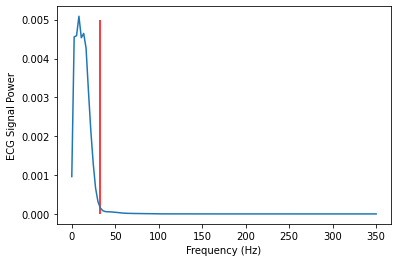

In [53]:
f, pxx = signal.welch(ecg.squeeze(), fs=700)
plt.plot(f, pxx)
plt.vlines(32, 0.0, 0.005, 'r')
plt.xlabel('Frequency (Hz)')
_ = plt.ylabel('ECG Signal Power')

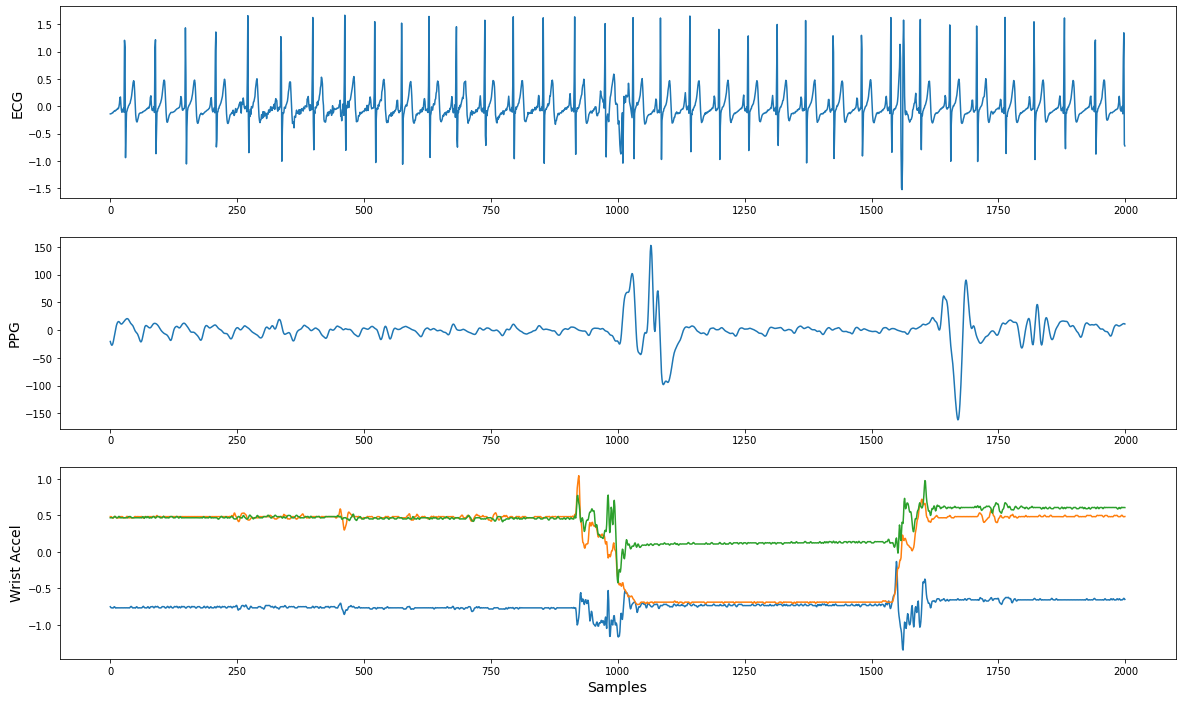

In [9]:
START = 250*8*64
END = 252*8*64

START = 1000
END = 3000

plt.figure(figsize=(20,12))

plt.subplot(3,1,1)
plt.plot(ecg_downsamp[START:END])
plt.ylabel('ECG', fontsize=14)

plt.subplot(3,1,2)
plt.plot(wrist_ppg.squeeze()[START:END])
plt.ylabel('PPG', fontsize=14)

plt.subplot(3,1,3)
_ = plt.plot(acc_interp[START:END])
plt.xlabel('Samples', fontsize=14)
_ = plt.ylabel('Wrist Accel', fontsize=14)

## Preprocessing

In [3]:
WINDOW = 8 # seconds
SHIFT = 2 # seconds
FS = 64
WAVELET_SCALE = 1000

def segment_signal(sig, labels, ref):
    frame_len = WINDOW * FS
    jump = SHIFT * FS
    sig_segmented = []
    ref_segmented = []
    
    sig_raw = sig / np.max(sig)
    
    orig = sig_raw
    

    b, a = signal.butter(4, 1.5, 'lowpass', fs=64)
    y1_filt_1 = signal.filtfilt(b, a, orig, padtype=None)
    
    b, a = signal.butter(4, 0.2, 'highpass', fs=64)
    y1_filt_2 = signal.filtfilt(b, a, y1_filt_1, padtype=None)

    sig = y1_filt_2 / np.max(y1_filt_2)
    
    widths = np.arange(1, 21)
    cwt_img = []
    
    no_frames = (len(sig) - frame_len) // (jump) + 1
    no_labels = len(labels)
    
    frame = 0
    
    while(frame * jump + frame_len) <= len(sig):
        sig_sub = sig[frame * jump : frame * jump + frame_len]
        ref_sub = ref[frame * jump : frame * jump + frame_len]
        sig_segmented.append(sig_sub / np.max(sig_sub))
        ref_segmented.append(ref_sub / np.max(ref_sub))
        sig_cwt = signal.cwt(sig_sub, signal.ricker, widths)
        cwt_img.append(sig_cwt)
        frame += 1
        
    truncated_sig_segmented = sig_segmented[:min(no_frames, no_labels)]
    truncated_ref_segmented = ref_segmented[:min(no_frames, no_labels)]
    truncated_labels = labels[:min(no_frames, no_labels)]
    
    return np.array(truncated_sig_segmented), np.array(cwt_img), truncated_labels, np.array(truncated_ref_segmented)

## Approach 1: Estimating heart rate based on peak detection

In [4]:
dd = {'train': list(range(1, 16)),
      'val':   list(range(8, 12)),
      'test': list(range(12, 16)) }

def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

def calculate_hr(what='train'):
    final_sig_segmented = []
    final_labels = []
    
    calculated_hr = []
    true_labels = []
    
    frame_len = WINDOW * FS
    jump = SHIFT * FS
    
    skipped = 0

    for sub_id in dd[what]:
        with open(f'PPG_FieldStudy/S{sub_id}/S{sub_id}.pkl', 'rb') as file:
            data_dict = pickle.load(file, encoding='latin1')
            
        wrist_signals = data_dict['signal']['wrist']
        wrist_ppg = wrist_signals['BVP']
        
        labels = data_dict['label']
        
        chest_signals = data_dict['signal']['chest']
        wrist_signals = data_dict['signal']['wrist']

        ecg = chest_signals['ECG'].squeeze()
        ecg_downsamp = signal.resample_poly(ecg, up=64, down=700)
        
        ref = ecg_downsamp / np.max(ecg_downsamp)
        
        sig_raw = wrist_ppg.squeeze() / np.max(wrist_ppg.squeeze())
        
        orig = sig_raw
        

        b, a = signal.butter(4, 2.0, 'lowpass', fs=64)
        y1_filt_1 = signal.filtfilt(b, a, orig, padtype=None)
        
        b, a = signal.butter(4, 0.2, 'highpass', fs=64)
        y1_filt_2 = signal.filtfilt(b, a, y1_filt_1, padtype=None)

        sig = y1_filt_2 / np.max(y1_filt_2)

        final_sig_segmented_np, cwt_img, final_labels, final_ref_segmented = segment_signal(orig, labels, ref)

        for idx in range(len(final_labels)):
            
            #pks, _ = signal.find_peaks(final_sig_segmented_np[idx, :])
            pks, _ = signal.find_peaks(final_ref_segmented[idx, :], threshold=0.2)
            
    
            diff_array = []
            for pos, elem in enumerate(pks[:-1]):
                diff_array.append(pks[pos + 1] - elem)
                
            diff_array = reject_outliers(np.array(diff_array), m=2)
            
            if not diff_array.shape[0]:
                skipped = 0
                calculated_hr.append(calculated_hr[-1])
                continue
                
            
            
            hr_array = [64 / elem * 60 for elem in diff_array]
            
            
            calc_hr = np.median(hr_array)
            
            if not calculated_hr:
                calculated_hr.append(calc_hr)
            elif calc_hr < 200 and calc_hr > 40: 
                calculated_hr.append(calc_hr)
            else: 
                calculated_hr.append(calculated_hr[-1])
            
        if skipped:
            break
        true_labels.extend(final_labels)

    return calculated_hr, true_labels


In [5]:
calculated_hr, true_labels = calculate_hr('train')

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


4.191347102780972


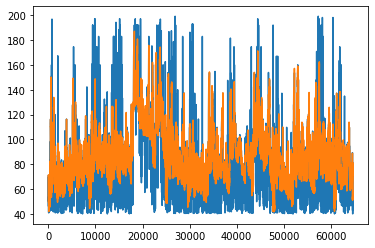

In [6]:
plt.plot(calculated_hr)
plt.plot(true_labels)
print(metrics.mean_absolute_error(true_labels, calculated_hr))

In [7]:
calculated_hr_filt = signal.savgol_filter(np.array(calculated_hr), window_length=11, polyorder=1)

4.084034536843759


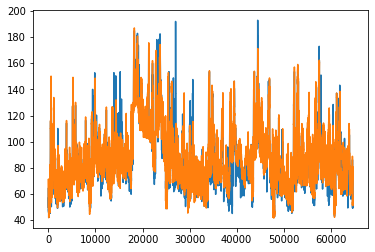

In [8]:
plt.plot(calculated_hr_filt)
plt.plot(true_labels)
print(metrics.mean_absolute_error(true_labels, calculated_hr_filt))

## Preprocessing 

In [5]:
WINDOW = 8 # seconds
SHIFT = 2 # seconds
FS = 64
WAVELET_SCALE = 1000

def align_signal_and_labels(sig, labels):
    frame_len = WINDOW * FS
    jump = SHIFT * FS
    sig_segmented = []
    
    
    no_frames = (len(sig) - frame_len) // (jump) + 1
    no_labels = len(labels)
    
    frame = 0
    
    while(frame * jump + frame_len) <= len(sig):
        sig_sub = sig[frame * jump : frame * jump + frame_len]
        sig_segmented.append(sig_sub / np.max(sig_sub))
        frame += 1
        
    truncated_sig_segmented = sig_segmented[:min(no_frames, no_labels)]
    truncated_labels = labels[:min(no_frames, no_labels)]
    
    return np.array(truncated_sig_segmented), truncated_labels

In [6]:
dd = {'train': list(range(1, 8)),
      'val':   list(range(8, 12)),
      'test': list(range(12, 16)) }


def prepare_data(what='train'):
    final_sig_segmented = []
    final_labels = []
    
    frame_len = WINDOW * FS
    jump = SHIFT * FS

    for sub_id in dd[what]:
        with open(f'PPG_FieldStudy/S{sub_id}/S{sub_id}.pkl', 'rb') as file:
            data_dict = pickle.load(file, encoding='latin1')
            
        wrist_signals = data_dict['signal']['wrist']
        wrist_ppg = wrist_signals['BVP']
        
        sig_raw = wrist_ppg.squeeze() / np.max(wrist_ppg.squeeze())
        
        orig = sig_raw
        

        b, a = signal.butter(4, 1.5, 'lowpass', fs=64)
        y1_filt_1 = signal.filtfilt(b, a, orig, padtype=None)
        
        
        b, a = signal.butter(4, 0.2, 'highpass', fs=64)
        y1_filt_2 = signal.filtfilt(b, a, y1_filt_1, padtype=None)

        sig = y1_filt_2 / np.max(y1_filt_2)

       
        truncated_sig_segmented, truncated_labels = align_signal_and_labels(sig, data_dict['label'])
        
        final_sig_segmented.append(truncated_sig_segmented)
        
        final_labels.extend(list(truncated_labels))
        
    final_sig_segmented_np = np.vstack(final_sig_segmented)
    
    
    return np.array(final_sig_segmented_np), np.array(final_labels)
    

In [7]:
def scale_labels():
    _, final_labels = prepare_data("train")
    MEAN = np.mean(final_labels)
    STD = np.std(final_labels)
    
    return MEAN, STD

In [8]:
dd = {'train': list(range(1, 8)),
      'val':   list(range(8, 12)),
      'test': list(range(12, 16)) }

WINDOW = 8 # seconds
SHIFT = 2 # seconds
FS = 64
WAVELET_SCALE = 1000
widths = np.arange(1, 31)

MEAN, STD = scale_labels()

def preprocess(what='train'):
    if not os.path.exists(os.path.join('keya_preprocessed_wdenoised', what)):
        os.makedirs(os.path.join('keya_preprocessed_wdenoised', what))
    
    frame_len = WINDOW * FS
    jump = SHIFT * FS
       
    final_sig_segmented = []
    final_ref_segmented = []
    final_cwt = []
    final_labels = []
    
    frame_len = WINDOW * FS
    jump = SHIFT * FS

    for sub_id in dd[what]:
        with open(f'PPG_FieldStudy/S{sub_id}/S{sub_id}.pkl', 'rb') as file:
            data_dict = pickle.load(file, encoding='latin1')
            print('File loaded')
        
        chest_signals = data_dict['signal']['chest']
        wrist_signals = data_dict['signal']['wrist']
        wrist_ppg = wrist_signals['BVP']
        
        sig = wrist_ppg.squeeze()
        
        sig_raw = sig / np.max(sig)
        
        orig = sig_raw
        
        b, a = signal.butter(4, 1.5, 'lowpass', fs=64)
        y1_filt_1 = signal.filtfilt(b, a, orig, padtype=None)
        
        b, a = signal.butter(4, 0.2, 'highpass', fs=64)
        y1_filt_2 = signal.filtfilt(b, a, y1_filt_1, padtype=None)

        sig = y1_filt_2 / np.max(y1_filt_2)
        
        ecg = chest_signals['ECG'].squeeze()
        ecg_downsamp = signal.resample_poly(ecg, up=64, down=700)
        
        ref = ecg_downsamp / np.max(ecg_downsamp)
        
        labels = data_dict['label']
        labels = (labels - MEAN) / STD
    
        no_frames = (len(sig) - frame_len) // (jump) + 1
        no_labels = len(labels)

        frame = 0
        sig_segmented = []
        ref_segmented = []
        cwt_img = []
        
        print(f'About to calculate frames for {sub_id}')
        while(frame * jump + frame_len) <= len(sig):
            sig_sub = sig[frame * jump : frame * jump + frame_len]
            ref_sub = ref[frame * jump : frame * jump + frame_len]
            ref_segmented.append(ref_sub / np.max(ref_sub))
            sig_segmented.append(sig_sub / np.max(sig_sub))
            frame += 1
        
        truncated_sig_segmented = sig_segmented[:min(no_frames, no_labels)]
        truncated_ref_segmented = ref_segmented[:min(no_frames, no_labels)]
        truncated_labels = labels[:min(no_frames, no_labels)]
        
        final_sig_segmented.append(truncated_sig_segmented)
        final_ref_segmented.append(truncated_ref_segmented)
        final_labels.extend(list(truncated_labels))
        
        gc.collect()
        
    final_sig_segmented_np = np.vstack(final_sig_segmented)
    final_ref_segmented_np = np.vstack(final_ref_segmented)
    

    dd_to_save = {'TD': final_ref_segmented_np,  
          'labels': np.array(final_labels)}
    
    np.save(os.path.join('keya_preprocessed_wdenoised', what, f'{what}.npy'), dd_to_save)

In [9]:
preprocess("train")

File loaded
About to calculate frames for 1
File loaded
About to calculate frames for 2
File loaded
About to calculate frames for 3
File loaded
About to calculate frames for 4
File loaded
About to calculate frames for 5
File loaded
About to calculate frames for 6
File loaded
About to calculate frames for 7


In [10]:
preprocess("val")

File loaded
About to calculate frames for 8
File loaded
About to calculate frames for 9
File loaded
About to calculate frames for 10
File loaded
About to calculate frames for 11


In [11]:
preprocess("test")

File loaded
About to calculate frames for 12
File loaded
About to calculate frames for 13
File loaded
About to calculate frames for 14
File loaded
About to calculate frames for 15


## Approach 2: Estimating heart rate using Neural Networks (Time Domain alone)

In [17]:
class DataGen_TD(keras.utils.Sequence):
    
    def __init__(self, what='train', batch_size=16, shuffle=False):
        self.what = what
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.dd_to_save = np.load(os.path.join('keya_preprocessed_wdenoised', self.what, f'{self.what}.npy'), allow_pickle=True)
        dd_to_save = self.dd_to_save.item()
        self.final_sig_segmented_np = dd_to_save['TD']
        self.final_labels = dd_to_save['labels']
        
    def __len__(self):    
        return int(np.ceil(self.final_sig_segmented_np.shape[0] / self.batch_size))
        
    def __getitem__(self, batch_num):
        
        final_sig_segmented, final_labels = self.final_sig_segmented_np, self.final_labels
        
        batch_size = self.batch_size             
        
        labels = final_labels[batch_num * batch_size : (batch_num + 1) * batch_size]
        
        td_all = final_sig_segmented[batch_num * batch_size : (batch_num + 1) * batch_size, :]
    
        td_all = np.expand_dims(td_all, -1)

        y = labels
        
        return np.array(td_all), np.array(y)
        
    def on_epoch_end(self):
        pass

In [18]:
train_gen = DataGen_TD(what='train', batch_size=16, shuffle=False)
val_gen = DataGen_TD(what='val', batch_size=16, shuffle=False)

In [28]:
def build_model_td():
    td_inp = keras.Input(shape=(512, 1), name='td_inp')
    
    # Time domain
    x = layers.Conv1D(64, 7, activation='relu')(td_inp)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(128))(x)
    time_output = layers.Dropout(0.2)(x)

    x = layers.Dense(128, activation='relu')(time_output)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    out = keras.layers.Dense(1)(x)
    
    
    model = keras.Model(inputs=td_inp, outputs=out)
    model.compile(
        loss='mae',
        optimizer=keras.optimizers.Adam(1e-4),
        metrics=['mse'],
    )
    
    return model

In [29]:
model = build_model_td()
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
td_inp (InputLayer)          [(None, 512, 1)]          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 506, 64)           512       
_________________________________________________________________
bidirectional_4 (Bidirection (None, 506, 128)          66048     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 256)               263168    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_9 (Dense)              (None, 128)               1651

In [30]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint('keya_model_td.h5', save_best_only=True, monitor='val_loss'),
]

history = model.fit(train_gen, 
                    callbacks=callbacks_list,
                    validation_data=val_gen, 
                    epochs=10,
                    verbose=1,
                    )

gc.collect()

Epoch 1/10
1849/1849 [==============================] - 123s 65ms/step - loss: 0.6167 - mse: 0.6474 - val_loss: 0.4719 - val_mse: 0.3877
Epoch 2/10
1849/1849 [==============================] - 120s 65ms/step - loss: 0.4024 - mse: 0.2857 - val_loss: 0.4018 - val_mse: 0.3237
Epoch 3/10
1849/1849 [==============================] - 120s 65ms/step - loss: 0.4047 - mse: 0.3042 - val_loss: 0.3822 - val_mse: 0.3364
Epoch 4/10
1849/1849 [==============================] - 120s 65ms/step - loss: 0.3587 - mse: 0.2422 - val_loss: 0.3445 - val_mse: 0.2475
Epoch 5/10
1849/1849 [==============================] - 121s 65ms/step - loss: 0.3302 - mse: 0.2125 - val_loss: 0.2746 - val_mse: 0.1524
Epoch 6/10
1849/1849 [==============================] - 121s 65ms/step - loss: 0.3132 - mse: 0.1948 - val_loss: 0.3687 - val_mse: 0.2250
Epoch 7/10
1849/1849 [==============================] - 120s 65ms/step - loss: 0.2685 - mse: 0.1425 - val_loss: 0.2796 - val_mse: 0.1639
Epoch 8/10
1849/1849 [===================

76166

Min Validation MAE:  0.15904200077056885


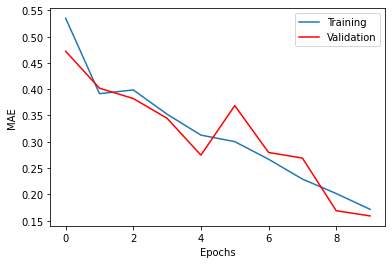

In [31]:
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], 'r', label='Validation')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

print("Min Validation MAE: ", np.min(history.history['val_loss']))

## Inference

In [32]:
test_gen = DataGen_TD('test', batch_size=16, shuffle=False)
no_of_test_files = len(test_gen)
model = keras.models.load_model('keya_model_td.h5')

In [24]:
MEAN, STD = scale_labels()

def inverse_scale_labels(y_pred_scaled):
    y_pred = [(x * STD + MEAN) for x in y_pred_scaled]
    return y_pred

In [33]:
BATCH_SIZE = 16

y_final = []
y_true = []
for batch in range(int(np.ceil(no_of_test_files / BATCH_SIZE))):
    y_final_scaled = model.predict(test_gen[batch][0])
    y_final.extend(inverse_scale_labels(y_final_scaled))
    y_true.extend(inverse_scale_labels(test_gen[batch][1]))

In [34]:
MAE =  metrics.mean_absolute_error(y_true, y_final)
print("Mean Absolute Error = ", MAE)

Mean Absolute Error =  5.622616950490123


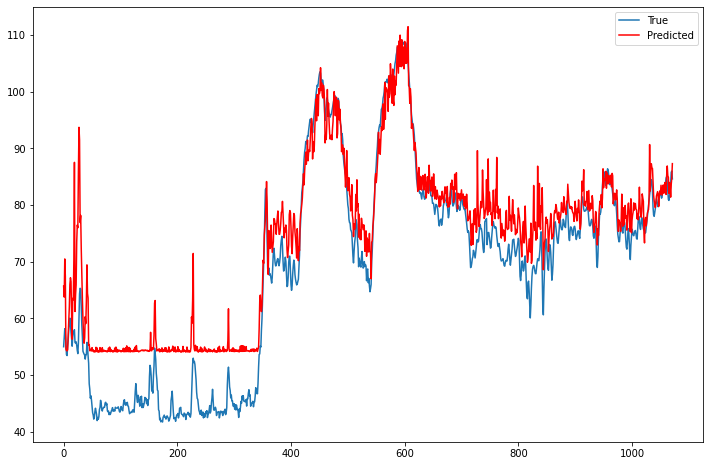

In [35]:
plt.figure(figsize=(12, 8))
plt.plot(y_true, label='True')
plt.plot(y_final, 'r', label='Predicted')
_ = plt.legend()

### Filtering the predicted heart rate

In [36]:
y_final_filt = signal.savgol_filter(np.array(y_final).squeeze(), window_length=11, polyorder=1)

In [37]:
MAE = metrics.mean_absolute_error(y_true, y_final_filt)
print("Mean Absolute Error = ", MAE)

Mean Absolute Error =  5.608930063983858


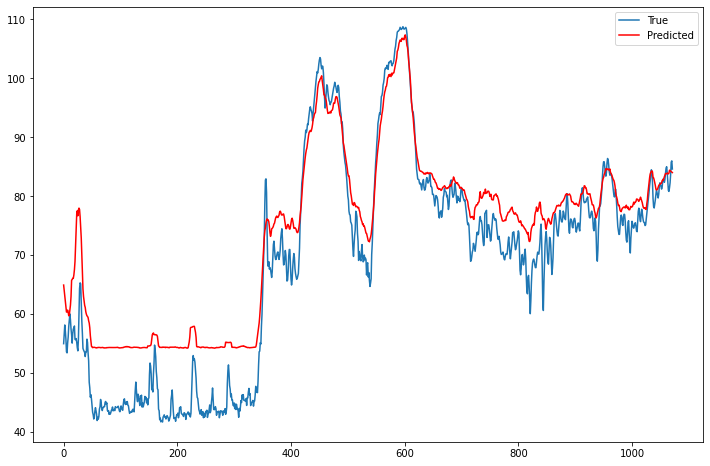

In [38]:
plt.figure(figsize=(12, 8))
plt.plot(y_true, label='True')
plt.plot(y_final_filt, 'r', label='Predicted')
_ = plt.legend()